In [5]:
from pandas import read_csv, DataFrame, concat
from datetime import datetime
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np 
import pandas as pd 



months = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 
          'June': 6, 'July': 7, 'August': 8, 'September': 9, 'October': 10,
         'November': 11, 'December': 12}

def encode(l):
    encoded = []
    for m in l:
        for key, value in months.items():
            if key == m:
                encoded.append(value)
    return encoded


def parse(x):
    return datetime.strptime(x, '%m/%d/%Y')

# Data Loading
data_set = pd.read_csv('march2020clean.csv', sep =',', date_parser = parse)
data_set = data_set.iloc[:data_set['totalSoybeanMealSupply'].last_valid_index(),:] # Truncate dataset to those where every data is available 
'''
'closePrice','openPrice','highPrice','lowPrice','totalSoybeanMealSupply','totalSoybeanMealDemand','soybeanOilSupply','soybeanOilDemand','sunflowerSeedPrice','canolaPrice','peanutsPrice','flaxseedPrice','soybeanOilPrice','cottonseedOilPrice','sunflowerseedOilPrice','canolaOilPrice','peanutOilPrice','cornOilPrice','soybeanMealPrice','cottonseedmealPrice','sunflowerseedMealPrice','linseedMealPrice'
'canolaOilPrice', 'soybeanOilPrice', 'soybeanMealPrice', 'cottonseedmealPrice', 'sunflowerseedMealPrice'
'''
target_col = ['closePrice','totalSoybeanMealSupply','totalSoybeanMealDemand', 'Month']
data_set['Month'] = encode(data_set['Month'])
data_set = data_set.loc[:,target_col]
shift = 8

In [6]:
data_set
values = data_set.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaler2 = MinMaxScaler()
scaled2 = scaler2.fit_transform(values[:,0].reshape(-1,1))


In [7]:
def series_to_supervised(data, seq_length, y_col):
    X = [] 
    Y = []
    for time in range(len(data)-seq_length):
        X += [data[time:time+seq_length]]
        Y += [data[time+seq_length][y_col]]
    
    return X,Y


data_x, data_y = scaled[:-shift], scaled[shift:]
separation = int(len(data_x)*0.8)
train_x, train_y = data_x[:separation], data_y[:separation]
test_x, test_y = data_x[separation:], data_y[separation:]
train_x = train_x.reshape(1, train_x.shape[0], train_x.shape[1])
train_y = train_y.reshape(1, train_y.shape[0], train_y.shape[1])
test_x = test_x.reshape(1, test_x.shape[0], test_x.shape[1])
test_y = test_y.reshape(1, test_y.shape[0], test_y.shape[1])
print(train_x.shape)
print(train_y.shape)

(1, 319, 4)
(1, 319, 4)


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

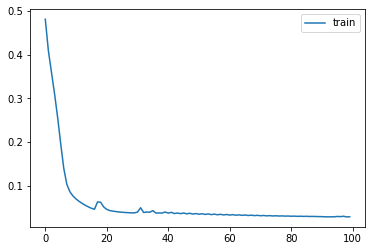

In [8]:
# design network
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    warmup_steps = 50
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, stateful = False, input_shape = (None, train_x.shape[2])))
regressor.add(LSTM(units = 4, return_sequences = True, stateful = False))
regressor.compile(optimizer = RMSprop(lr=1e-3), loss = loss_mse_warmup)

history = regressor.fit(train_x, train_y, epochs = 100, verbose=3)

# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# print(model.get_weights())

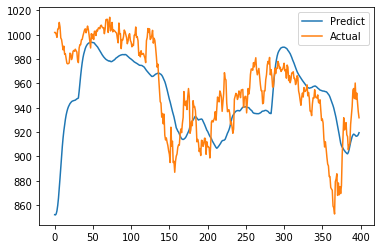

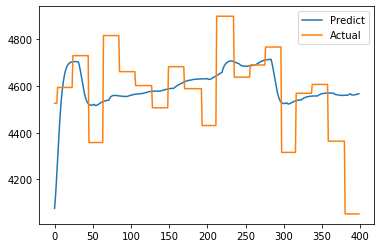

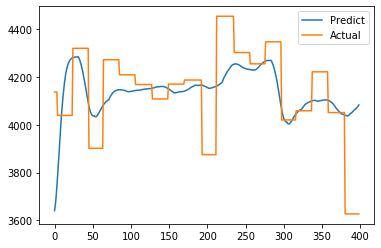

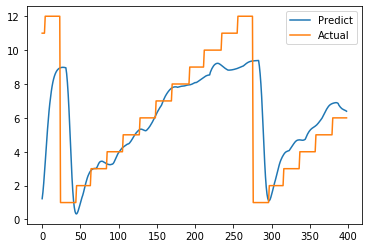

In [11]:
newModel = Sequential()
newModel.add(LSTM(units = 50, return_sequences = True, stateful = True, batch_input_shape = (1, None, train_x.shape[2])))
newModel.add(LSTM(units = 4, return_sequences = False, stateful = True))

newModel.set_weights(regressor.get_weights())
forecast_length = 200 

'''
10/25 Morning 

forecastFromSelf = np.empty((1, train_x.shape[1] + forecast_length, train_x.shape[2]))
forecastData = np.empty((1, train_x.shape[1] + forecast_length, train_x.shape[2]))
forecastData[:,:train_x.shape[1], :] = train_x[:,:,:]
for i in range(train_x.shape[1]):
    forecastFromSelf[:,i:i+1,:] = newModel.predict(forecastData[:,i:i+1,:])
    if i + shift >= train_x.shape[1] and i + shift < forecastData.shape[1]:
        forecastData[:,i+shift:i+shift+1,:] = forecastFromSelf[:,i:i+1,:]

'''
'''
totalLength = 400
lastSteps = np.empty((1,totalLength-train_x.shape[1],train_x.shape[2])) #includes a shift at the beginning to cover the gap 
lastSteps[:,:shift] = train_x[:,-shift:] #the initial shift steps are filled with x training data 
newModel.predict(train_x[:,:-shift,:]).reshape(1,1,train_x.shape[2]) #just to adjust states, predict with x without the last shift elements


rangeLen = totalLength-train_x.shape[1]-shift
print('rangeLen: ', rangeLen)
for i in range(rangeLen):
    lastSteps[:,i+shift] = newModel.predict(lastSteps[:,i:i+1,:]).reshape(1,1,train_x.shape[2])
print(lastSteps.shape)
forecastFromSelf = lastSteps[:,shift:,:]
print(lastSteps[0,:50,:])
'''
y_hat = scaler.inverse_transform(forecastFromSelf.reshape((forecastFromSelf.shape[1],forecastFromSelf.shape[2])))[:,0]

pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
a = regressor.predict(data_x.reshape(1, data_x.shape[0], data_x.shape[1])) 
a = a.reshape(a.shape[1], a.shape[2])
a = scaler.inverse_transform(a)
b = data_y.reshape(1, data_x.shape[0], data_x.shape[1])
b = b.reshape(b.shape[1], b.shape[2])
b = scaler.inverse_transform(b)
pyplot.plot(a[:,0], label='Predict')
pyplot.plot(b[:,0], label='Actual')
pyplot.legend()
pyplot.show()

pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
pyplot.plot(a[:,1], label='Predict')
pyplot.plot(b[:,1], label='Actual')
pyplot.legend()
pyplot.show()

pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
pyplot.plot(a[:,2], label='Predict')
pyplot.plot(b[:,2], label='Actual')
pyplot.legend()
pyplot.show()

pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
# pyplot.plot(y_hat, label = 'Forecast')
pyplot.plot(a[:,3], label='Predict')
pyplot.plot(b[:,3], label='Actual')
pyplot.legend()
pyplot.show()

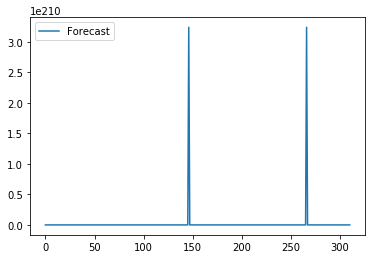

In [301]:
forecast_distance = 300

x_given = test_x

x_hat = np.zeros((x_given.shape[1] + forecast_distance, x_given.shape[2]))
print(x_hat.shape)
x_hat[:x_given.shape[1],:] = x_given 
y_hat = np.zeros((x_given.shape[1] + forecast_distance))
print(x_hat.shape)
for i in range(shift, len(x_given)+forecast_distance):
    pred = regressor.predict(x_hat[i-shift:i,:].reshape(1,shift, x_given.shape[2]))
    if i >= x_given.shape[1]:
        x_hat[i,:] = pred 
    y_hat[i] = pred[0,0]
    #predictor.reset_states()

y_hat = y_hat[shift:]
    
#yhat2 = regressor.predict(test_x)[:,0]

# invert scaling for forecast
inv_yhat = scaler2.inverse_transform(y_hat.reshape(-1,1))
# invert scaling for forecast
#inv_yhat2 = scaler2.inverse_transform(yhat2.reshape(-1,1))
# invert scaling for actual
#inv_y = scaler2.inverse_transform(np.concatenate((train_y[:,0],test_y[:,0]), axis=0).reshape(-1,1))


pyplot.figure()
#pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Forecast')
#pyplot.plot(inv_yhat2, label = 'Forecast2')
pyplot.legend()
pyplot.show()

(380, 4)
(380, 4)


ValueError: setting an array element with a sequence.